# Reddit users banned for "interference" 2018 - 2019
### Context:
In 2018 Reddit banned 944 accounts on suspicion of interference by the Russian government:
[First "banwave" where 944 users were banned from reddit in 2018](https://www.reddit.com/r/announcements/comments/8bb85p/reddits_2017_transparency_report_and_suspect/)

A year later, it again banned 61 accounts however this time the target of the suspicious accounts was the UK Election of December 2019:
[Second wave of banning users just before the UK elections in December 2019](https://www.reddit.com/r/announcements/duplicates/e75f07/suspected_campaign_from_russia_on_reddit/)

Data comes from a JSON file generated by a python script (reddit-get-data.py) that scrapes the users profile listed in these two links.

### Data preparation

In [1]:
import pandas as pd
from pandas.io.json import json_normalize
import json
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS 

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
%matplotlib inline


In [2]:
# sentiment analysis, wordcloud

# %pip install wordcloud
#import nltk
#nltk.download('vader_lexicon')
# nltk.download("popular")
# nltk.download('punkt')

In [3]:
# import the json file containint data on 1001 banned Reddit users
rawdata = pd.read_json("data-files/reddit-banned-users-DATA.json")

In [4]:
# reverse rows/columns T short for transverse
rawdata = rawdata.T

In [5]:
rawdata.shape

(1000, 6)

In [6]:
#normalizing "about" column, including suspended accounts
about = json_normalize(rawdata["about"])

In [7]:
# appending banwave_year to about dataframe
about["banwave_year"] = rawdata["banwave_year"].values

In [8]:
# isolating suspended account in a separate dataframe
suspended = rawdata.loc[[x for x in rawdata.index if "is_suspended" in rawdata.loc[x]["about"]]]

In [9]:
#removing it to clean the rest of the data
rawdata.drop(suspended.index, axis=0, inplace=True)

In [10]:
#deeper levels of nesting
temp_trophies = json_normalize(rawdata["trophies"])
gilded = json_normalize(rawdata["gilded"])

# submitted and comments have deeper levels of nested json
temp_submitted = json_normalize(rawdata["submitted"])
temp_comments = json_normalize(rawdata["comments"])

In [11]:
# get to the "data" field in nested levels for "comments", "submitted" and "trophies"
def go_to_data(node):
    lst = []
    for i in range(len(node)): # iterate through data series
        entry = node.loc[i] # for clarity
        if "children" in node:
            container = "children"
        elif "trophies" in node:
            container = "trophies"
        if len(entry[container]) > 0: 
            for j in range(len(entry[container])):
                lst.append(entry[container][j]["data"])
    return json_normalize(lst)

In [12]:
submitted =  go_to_data(temp_submitted)
comments =  go_to_data(temp_comments)
trophies = go_to_data(temp_trophies)

In [82]:
submitted.shape

(2909, 45)

In [14]:
# dropping duplicates values
submitted.drop_duplicates(subset="name", keep='first', inplace=True)
comments.drop_duplicates(subset="body", keep='first', inplace=True)
about.drop_duplicates(subset="name", keep='first', inplace=True)

In [15]:
# isolating nested media_metadata data: url (s.u) type (m))
metadata_col_type = [ x for x in [x for x in submitted.columns if "media_metadata" in x] if ".m" in x]
metadata_col_url = [ x for x in [x for x in submitted.columns if "media_metadata" in x] if "s.u" in x]
metadata_col_id = [ x for x in [x for x in submitted.columns if "media_metadata" in x] if ".id" in x]

In [16]:
# consolidating the 60 metadata id and url columns into two new columns
submitted["metadata_type"] = submitted[metadata_col_type].apply(lambda x: "".join(x.dropna().astype(str)), axis=1)
submitted["metadata_url"] = submitted[metadata_col_url].apply(lambda x: "".join(x.dropna().astype(str)), axis=1)
submitted["metadata_id"] = submitted[metadata_col_id].apply(lambda x: "".join(x.dropna().astype(str)), axis=1)

In [17]:
# removing columns with "media_metadata" except type ("m") unique id and url
submitted.drop([x for x in submitted.columns if "media_metadata" in x and x != "metadata_col_type" and x != "metadata_col_url" and x != "metadata_col_id"], axis=1, inplace=True)
submitted.drop([x for x in submitted.columns if "secure_media" in x], axis=1, inplace=True)
submitted.drop([x for x in submitted.columns if "media_embed" in x], axis=1, inplace=True)
# removing media_oembed columns except "provider_name", "type", "url", "author_name"
submitted.drop([x for x in submitted.columns if "media.oembed" in x and x != "media.oembed.provider_name" and x != "media.oembed.type" and x != "media.oembed.url" and x != "media.oembed.author_name"], axis=1, inplace=True)

#removing columns about "flair"
submitted.drop([x for x in submitted.columns if "flair" in x], axis=1, inplace=True)
comments.drop([x for x in comments.columns if "flair" in x], axis=1, inplace=True)
#removing columns about "thumbnail"
submitted.drop([x for x in submitted.columns if "thumbnail" in x], axis=1, inplace=True)
comments.drop([x for x in comments.columns if "thumbnail" in x], axis=1, inplace=True)
# removing columns with "subreddit" in "about" since they all contain users subreddits
about.drop([x for x in about.columns if "subreddit" in x], axis=1, inplace=True)
# removing the u_reddit subreddit
submitted.drop(submitted[submitted["subreddit"] == "u_reddit"].index, inplace=True)
# dropping columns with all n/a values
submitted.dropna(axis=1, how="all", inplace=True)
comments.dropna(axis=1, how="all", inplace=True)
about.dropna(axis=1, how="all", inplace=True)
#other columns
to_drop_submitted = ["subreddit_name_prefixed", "wls", "pwls", "allow_live_comments", 
                     "content_categories", "preview.enabled", "whitelist_status", "send_replies",
                    "post_hint", "is_robot_indexable","suggested_sort", "author_premium", "all_awardings",
                    "preview.images", "preview.enabled", "subreddit_id", "parent_whitelist_status"]
to_drop_comments = ["subreddit_name_prefixed", "all_awardings", "author_premium", "permalink"]
submitted.drop(to_drop_submitted, axis=1, inplace=True)
comments.drop(to_drop_comments, axis=1, inplace=True)

In [18]:
# rename gildings gid_1 silver gid_2 gold
submitted = submitted.rename(columns={"gildings.gid_1": "gilded_silver", "gildings.gid_2": "gilded_gold"})
comments = comments.rename(columns={"gildings.gid_1": "gilded_silver", "gildings.gid_2": "gilded_gold"})
# creating new column in about for total karma
about["karma"] = about["comment_karma"] + about["link_karma"]

In [19]:
# select all columns where same value is in all rows
def show_same_values(node):
    return [x for x in node.columns if node[x].value_counts().iloc[0] == len(node[x])]

In [20]:
# keeping these columns in a separate dataframe just in case
same_values_submitted = submitted[show_same_values(submitted)]
same_values_comments = comments[show_same_values(comments)]
same_values_about = about[show_same_values(about)]

In [21]:
# drop these same values columns from the data
submitted.drop(same_values_submitted, axis=1, inplace=True)
comments.drop(same_values_comments, axis=1, inplace=True)

In [22]:
# merging all back - just in case
#all_data = about.merge(submitted, how="inner", left_on="name", right_on="author").merge(comments, how="inner", left_on="author", right_on="author")

In [23]:
# date conversion of "created_utc" and "edited" fields in "comments" and "submitted" tables
def convert_dates(*args):
    for node in args: #dealing with subsets
        if "created_x_utc" in node.columns:
            node["date_posted"] = pd.to_datetime(node["created_x_utc"], unit="s")
        else:
            node["date_created"] = pd.to_datetime(node["created_utc"], unit="s")
            node["year_graph"] = pd.DatetimeIndex(node["date_created"]).year
            node["year"] = pd.PeriodIndex(node["date_created"], freq='A')
            node["month_nr"] = pd.PeriodIndex(node["date_created"], freq="M")
            node["month"] = pd.DatetimeIndex(node["date_created"]).month_name()
            node["day"] =pd.PeriodIndex(node["date_created"], freq="D")
            node["day_of_week"] = pd.DatetimeIndex(node["date_created"]).day_name()       

convert_dates(submitted, comments, about)
# rename "date_created" columns in submitted and columns to avoid confusion
submitted.rename(columns={"date_created": "date_posted"}, inplace=True)
comments.rename(columns={"date_created": "date_posted"}, inplace=True)

In [24]:
# creating subsets reflecting the 2018 and 2019 banwaves
about_banwave_2018 = about[about["banwave_year"] == "2018-May-09"]
about_banwave_2019 = about[about["banwave_year"] == "2019-Dec-06"]

# merging with submitted and comments df using "about["name"]" and "["author"]" as key
submitted_banwave_2018 = submitted.merge(about_banwave_2018, how="inner", left_on="author", right_on="name")
submitted_banwave_2019 = submitted.merge(about_banwave_2019, how="inner", left_on="author", right_on="name")
comments_banwave_2018 = comments.merge(about_banwave_2018, how="inner", left_on="author", right_on="name")
comments_banwave_2019 = comments.merge(about_banwave_2019, how="inner", left_on="author", right_on="name")

# Analysis

In [25]:
# no downvotes on any submission
same_values_submitted["downs"].value_counts()

0    2909
Name: downs, dtype: int64

In [26]:
# no downvotes in comments either
same_values_comments["downs"].value_counts()

0    1736
Name: downs, dtype: int64

## Users banned in 2018 

### User creation over the years, users banned in 2018

(array([ 0.,  5., 10., 15., 20., 25., 30., 35.]),
 <a list of 8 Text xticklabel objects>)

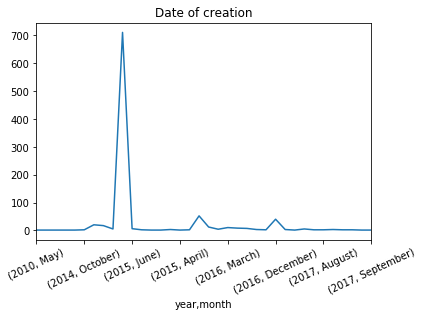

In [27]:
# Create the figure and the axes
fig, ax = plt.subplots()
# Set limits and labels
ax.set(title='Date of creation')

banned_2018 = about_banwave_2018.groupby(["year", "month"]).count().sort_values(by="year")["id"].plot(kind="line")
plt.xticks(rotation=25)

In [28]:
# banned_2018_line = about_banwave_2018.groupby(["year_graph", "month"], as_index=False).count().sort_values(by="year_graph")

# fig = px.line(banned_2018_line, x="year_graph", y="id", title="Account creation dates")
# fig.show()

### Subreddits most used by users banned in 2018

In [29]:
# top_subreddits_2018.sort_values().plot(kind="barh")
# plt.xticks(rotation=90)

top_subreddits_2018 = submitted_banwave_2018.groupby("subreddit", as_index=False).count().sort_values(by="score", ascending=False).head()
fig = px.bar(top_subreddits_2018.sort_values(by="score", ascending=True), y="subreddit", x="score",  orientation='h',
             hover_data=["subreddit"], color="score",
             labels={'Score':'Nr of posts'}, height=400
            )
fig.show()

## Users banned in 2019

### User creation over the years, users banned in 2019

(array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18.]),
 <a list of 10 Text xticklabel objects>)

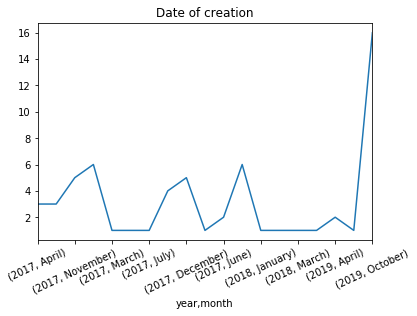

In [30]:
# user creation over the years, 2019 banwave group
# Create the figure and the axes
fig, ax = plt.subplots()
ax.set(title='Date of creation')
about_banwave_2019.groupby(["year", "month"]).count().sort_values(by="year")["id"].plot(kind="line")
plt.xticks(rotation=25)

### Subreddits most used by users banned in 2018

In [31]:
#top_subreddits_2019.sort_values().plot(kind="barh")
top_subreddits_2019 = submitted_banwave_2019.groupby("subreddit", as_index=False).count().sort_values(by="score", ascending=False).head(7)
fig = px.bar(top_subreddits_2019.sort_values(by="score", ascending=True), y="subreddit", x="score",  orientation='h',
             hover_data=["subreddit"], color="score",
             labels={'Score':'Nr of posts'}, height=400
            )
fig.show()

### Yearly trends

### Posts

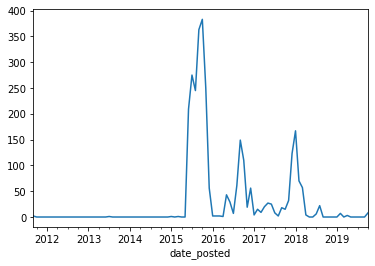

In [83]:
#  Posts 
yearly_trend_submitted = submitted[["score", "author", "subreddit", "title","date_posted"]].sort_values(by="score", ascending=False)
yearly_trend_submitted.groupby(pd.Grouper(key='date_posted', freq='M')).size().plot()

### Spikes in post, by months

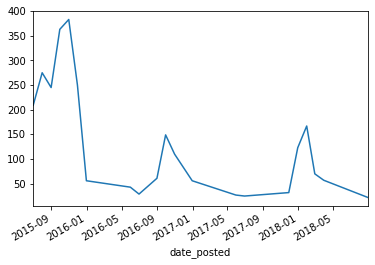

In [136]:
#  Posts 
yearly_trend_submitted = submitted[["score", "author", "subreddit", "title","date_posted"]]
monthly_trend = yearly_trend_submitted.groupby(pd.Grouper(key='date_posted', freq='M'), as_index=False).size().sort_index()
monthly_trend[monthly_trend > 20].plot()

### Comments

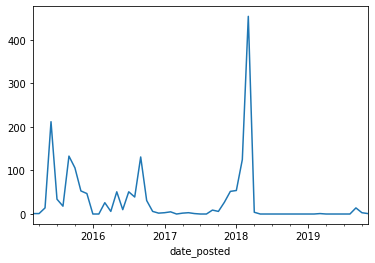

In [33]:
#  Comments 
yearly_trend_comments = comments[["score", "author", "subreddit","link_title", "body","date_posted"]].sort_values(by="score", ascending=False)
yearly_trend_comments.groupby(pd.Grouper(key='date_posted', freq='M')).size().plot()

### Subreddits with most upvoted comments

In [34]:
# top comments
top_comments = comments.groupby("subreddit", as_index=False)["score"].sum().sort_values(by="score", ascending=False).head(5)

fig = px.bar(top_comments.sort_values(by="score", ascending=True), y="subreddit", x="score",  orientation='h',
             hover_data=["subreddit"], color="score",
             labels={"score": "score"}, height=400
            )
fig.show()

### Year 2016 - US Election

### Number of posts in 2016 - monthy

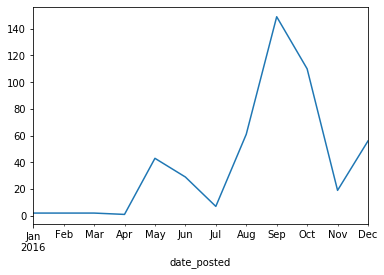

In [35]:
#  Posts for the year 2016 - peak in september 2016
top_2016_submitted = submitted[submitted["year"] == 2016].sort_values(by="score", ascending=False)
top_2016_submitted.groupby(pd.Grouper(key='date_posted', freq='M')).size().plot()

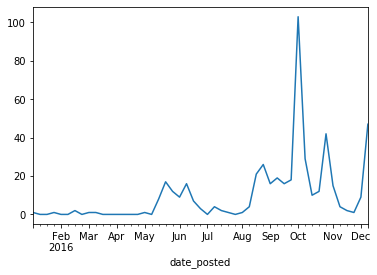

In [36]:
#  Posts for the year 2016 - peak in october 2016
top_2016_submitted = submitted[submitted["year"] == 2016].sort_values(by="score", ascending=False)
top_2016_submitted.groupby(pd.Grouper(key='date_posted', freq='W')).size().plot()

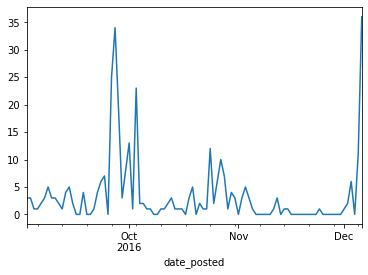

In [37]:
#  Posts for the year 2016 - peak in october 2016
top_late_2016 = submitted[submitted["date_posted"].between("2016-09-01", "2016-12-31")][["date_posted","title","day"]]
top_late_2016.groupby(pd.Grouper(key='date_posted', freq='D')).size().plot()
#top_late_2016["day"].value_counts().sort_values()
#top_late_2016.groupby(pd.Grouper(key='date_posted', freq='D')).size().plot()
#fig = px.line(late_2016_line, x="value", y=top_late_2016.index, title='Line')
#fig.show()

### Subreddits where the users were most active, 2016

In [38]:
top_subreddits_2016_bar1 = submitted[submitted["year"] == 2016].groupby("subreddit", as_index=False).count().sort_values(by="score", ascending=False).head(10)
fig = px.bar(top_subreddits_2016_bar1.sort_values(by="num_comments"), y="subreddit", x="id",  orientation='h',
             hover_data=["subreddit"], color="score",
             labels={'id':'Nr of posts'}, height=400
            )
fig.show()

### Subreddit with posts generating the most comments, 2016

In [39]:
top_subreddits_2016_bar2 = submitted[submitted["year"] == 2016].groupby("subreddit", as_index=False).sum().sort_values(by="num_comments", ascending=False).head(10)
fig = px.bar(top_subreddits_2016_bar2.sort_values(by="num_comments"), y="subreddit", x="num_comments",  orientation='h',
             hover_data=["subreddit"], color="num_comments",
             labels={'num_comments':'Nr of comments'}, height=400
            )
fig.show()

###  Top comments in 2016

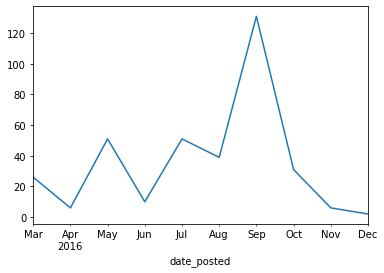

In [40]:
#  Comments for the year 2016 - 
comments_2016 = comments[comments["year"] == 2016].sort_values(by="id", ascending=False)
comments_2016.groupby(pd.Grouper(key='date_posted', freq='M')).size().plot()

### Subreddits with most upvoted comments, 2016

In [41]:
top_comments_2016_bar = comments[comments["year"] == 2016].groupby("subreddit", as_index=False).sum().sort_values(by="score", ascending=False).head(10)
fig = px.bar(top_comments_2016_bar.sort_values(by="score"), y="subreddit", x="score",  orientation='h',
             hover_data=["subreddit"], color="score",
             labels={'Score':'Nr of posts'}, height=400
            )
fig.show()

### Year 2019 

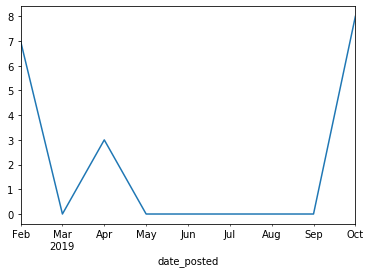

In [42]:
#  Posts for the year 2019 - 
top_2019_submitted = submitted[submitted["year"] == 2019][["score", "author", "subreddit", "title","date_posted"]].sort_values(by="score", ascending=False)
top_2019_submitted.groupby(pd.Grouper(key='date_posted', freq='M')).size().plot()

### Subreddits generating the most comments, 2019

In [43]:
top_subreddits_2019_bar = submitted[submitted["year"] == 2019].groupby("subreddit", as_index=False).sum().sort_values(by="num_comments", ascending=False).head(10)
fig = px.bar(top_subreddits_2019_bar.sort_values(by="num_comments"), y="subreddit", x="num_comments",  orientation='h',
             hover_data=["subreddit"], color="num_comments",
             labels={"num_comments":'Nr of posts'}, height=400
            )
fig.show()

# Analyzing content

In [44]:
from nltk.tokenize import RegexpTokenizer 
from nltk.stem.porter import PorterStemmer

In [45]:
custom_list=["jj", "oo"] # filter some additional words
def stem_text(text):    
    stemmer = PorterStemmer()
    tokenizer = RegexpTokenizer(r"\w+")
    text_token = tokenizer.tokenize(text.lower())
    return " ".join([stemmer.stem(x) for x in text_token if x not in stopwords.words(["english", "spanish"]) and x not in custom_list])

def lem_text(text): # "lemmarize" text to get real words from all their variations
    tokenizer = RegexpTokenizer(r"\w+")
    text_token = tokenizer.tokenize(text.lower())
    lmtzr = WordNetLemmatizer()
    return " ".join( [lmtzr.lemmatize(x) for x in text_token if x not in stopwords.words(["english", "spanish"])and x not in custom_list] )

def filter_text(text):    
    tokenizer = RegexpTokenizer(r"\w+")
    text_token = tokenizer.tokenize(text.lower())  
    return " ".join([x for x in text_token if x not in stopwords.words(["english", "spanish"])and x not in custom_list])


In [46]:
# different filters for the titles
submitted_banwave_2018_stemmed_text = submitted_banwave_2018["title"].apply(stem_text)
submitted_banwave_2019_lemmarized_text = submitted_banwave_2019["title"].apply(lem_text)
# for comments
comments_lemmarized_text = comments["body"].apply(lem_text)

### Posts by users banned in 2018

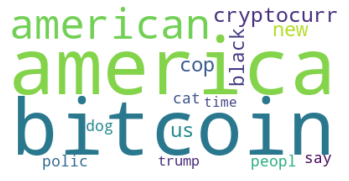

In [47]:
# Wordcloud of submission titles users banned in 2018
submitted_2018_wordcloud = WordCloud(max_words=15, background_color="white").generate(' '.join(submitted_banwave_2018_stemmed_text))

plt.imshow(submitted_2018_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Posts by users banned in 2019

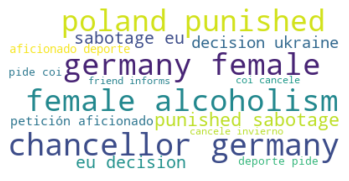

In [48]:
# Wordcloud of submitssion titles users banned in 2019
submitted_2019_wordcloud = WordCloud(collocations=True, max_words=15, background_color="white").generate(' '.join(submitted_banwave_2019_lemmarized_text))
plt.imshow(submitted_2019_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Comments by all users

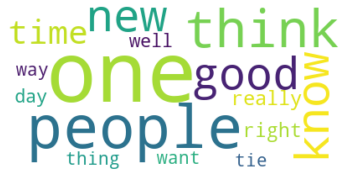

In [49]:
# wordcloud of all comments
comments_wordcloud = WordCloud(max_words=15, background_color="white").generate(" ".join(comments_lemmarized_text))
plt.imshow(comments_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Sentiment Analysis

In [50]:

# https://github.com/dend/data-explorations/blob/master/notebooks/sentiment-analysis-reddit.ipynb
sia = SentimentIntensityAnalyzer()
def analyze_content(title):
    text_list = []
    for line in title:
        pol_score = sia.polarity_scores(line)
        pol_score['text'] = line
        text_list.append(pol_score)
    result = pd.DataFrame.from_records(text_list)
    result["sentiment"] = 0
    result.loc[result["compound"] > 0.1, "sentiment"] = "positive"
    result.loc[result["compound"] < -0.1, "sentiment"] = "negative"
    result.loc[result["compound"].between(-0.1, 0.1) , "sentiment"] = "neutral"
    return result

In [51]:
sentiment_analysis_submitted = analyze_content(submitted["title"])
sentiment_analysis_comments = analyze_content(comments["body"])
sentiment_analysis_submitted_banwave_2019 = analyze_content(submitted_banwave_2019["title"])

## Sentiment analysis of posts

In [52]:
group = sentiment_analysis_submitted.groupby("sentiment", as_index=False).count()
colors = ["lightcoral", "lightblue", "lightgreen"]
fig = go.Figure(data=[go.Bar(x=group["sentiment"], y=group["pos"], orientation='v',
                    marker_color=colors,)])

fig.update_layout(title_text="Sentiment analysis of posts")

### Sentiment analysis of comments

In [53]:
group = sentiment_analysis_comments.groupby("sentiment", as_index=False).count()
fig = go.Figure(data=[go.Bar(x=group["sentiment"], y=group["pos"], orientation='v',
                    marker_color=colors,)])

fig.update_layout(title_text="Sentiment analysis of comments")

### Words used in positive and negative posts and comments 

In [54]:
# function that generates lists of word in negative, neutral and positive sentiments. Then generate wordcloud
def classify_sentiment(table):
    list_neg, list_neu, list_pos = [], [], []
    if "text" in table.columns and "sentiment" in table.columns:
        for i in range(len(table)):
            row = table.loc[i] 
            if "negative" in row["sentiment"]:
                list_neg.append(row["text"])
            elif "positive" in row["sentiment"]:
                list_pos.append(row["text"])
            else:
                list_neu.append(row["text"])
        result = pd.DataFrame({"negative":pd.Series(list_neg),"neutral":pd.Series(list_neu), "positive":pd.Series(list_pos) })
        return result.fillna("")
                

In [55]:
# categorizes posts and comments according to sentiment analysis
classified_submitted = classify_sentiment(sentiment_analysis_submitted)
classified_comments = classify_sentiment(sentiment_analysis_comments)
classified_submited_banwave_2019 = classify_sentiment(sentiment_analysis_submitted_banwave_2019)
# generates lists of words for wordclouds
classified_submitted_neg = classified_submitted["negative"].apply(lem_text)
classified_submitted_pos = classified_submitted["positive"].apply(lem_text)
classified_submitted_neu = classified_submitted["neutral"].apply(lem_text)
classified_submited_banwave_2019_pos = classified_submited_banwave_2019["positive"].apply(lem_text)
classified_submited_banwave_2019_neg = classified_submited_banwave_2019["negative"].apply(lem_text)
classified_submited_banwave_2019_neu = classified_submited_banwave_2019["neutral"].apply(lem_text)


classified_comments_neg = classified_comments["negative"].apply(lem_text)
classified_comments_pos = classified_comments["positive"].apply(lem_text)
classified_comments_neu = classified_comments["neutral"].apply(lem_text)

### Wordcloud of all negative posts

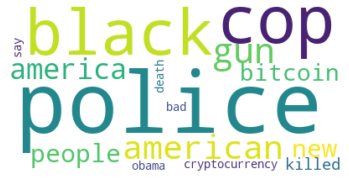

In [56]:
# wordcloud of all negative posts
submitted_neg_wordcloud = WordCloud(max_words=15, background_color="white").generate(" ".join(classified_submitted_neg))
plt.imshow(submitted_neg_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Wordcloud of all positive posts

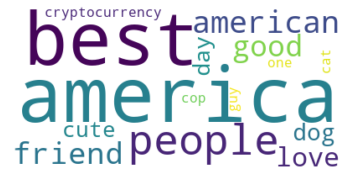

In [57]:
# wordcloud of all positive posts
submitted_pos_wordcloud = WordCloud(max_words=15, background_color="white").generate(" ".join(classified_submitted_pos))
plt.imshow(submitted_pos_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Wordcloud of all negative posts - banned in 2019

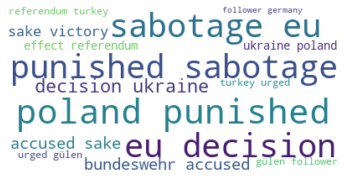

In [58]:
# wordcloud of all negative posts - banned in 2019
submitted_pos_wordcloud_banwave_2019_neg = WordCloud(max_words=15, background_color="white").generate(" ".join(classified_submited_banwave_2019_neg))
plt.imshow(submitted_pos_wordcloud_banwave_2019_neg, interpolation="bilinear")
plt.axis("off")
plt.show()

### Wordcloud of all positive posts - banned in 2019

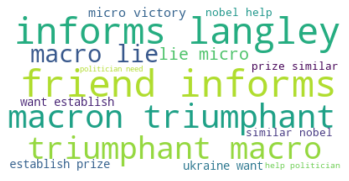

In [59]:
# wordcloud of all positive posts - banned in 2019
submitted_pos_wordcloud_banwave_2019_pos = WordCloud(max_words=15, background_color="white").generate(" ".join(classified_submited_banwave_2019_pos))
plt.imshow(submitted_pos_wordcloud_banwave_2019_pos, interpolation="bilinear")
plt.axis("off")
plt.show()

### Wordcloud of all negative comments

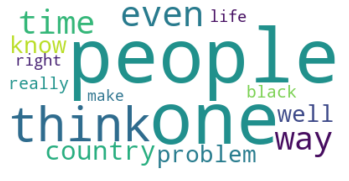

In [60]:
# wordcloud of all negative comments
comments_neg_wordcloud = WordCloud(max_words=15, background_color="white").generate(" ".join(classified_comments_neg))
plt.imshow(comments_neg_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Wordcloud of all positive comments

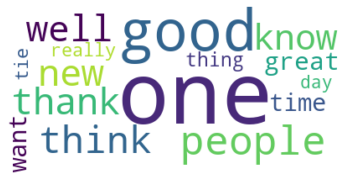

In [61]:
# wordcloud of all positive comments
comments_pos_wordcloud = WordCloud(max_words=15, background_color="white").generate(" ".join(classified_comments_pos))
plt.imshow(comments_pos_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Wordcloud of all neutral posts

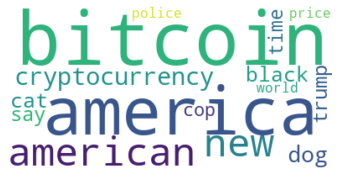

In [62]:
# wordcloud of all neutral posts
submitted_neu_wordcloud = WordCloud(max_words=15, background_color="white").generate(" ".join(classified_submitted_neu))
plt.imshow(submitted_neu_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Wordcloud of all neutral comments

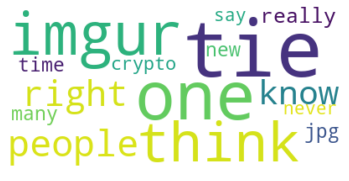

In [63]:
# wordcloud of all neutral comments
comments_neu_wordcloud = WordCloud(max_words=15, background_color="white").generate(" ".join(classified_comments_neu))
plt.imshow(comments_neu_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Wordcloud of all neutral posts - banned in 2019

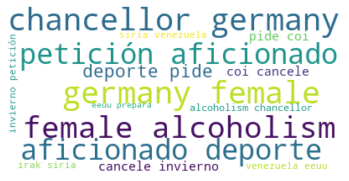

In [64]:
# wordcloud of all neutral posts - banned in 2019
submitted_pos_wordcloud_banwave_2019_neu = WordCloud(max_words=15, background_color="white").generate(" ".join(classified_submited_banwave_2019_neu))
plt.imshow(submitted_pos_wordcloud_banwave_2019_neu, interpolation="bilinear")
plt.axis("off")
plt.show()

## To add? where users actives after 2016 elections?

## Daily/Weekly Spikes to see coordinated posting

### Unused

In [65]:
# creating groups 
top_submit_2018 = submitted_banwave_2018[submitted_banwave_2018["ups"] > 1000]
top_submit_2019 = submitted_banwave_2019[submitted_banwave_2019["ups"] > 10]
top_comments_2019 = comments_banwave_2019[comments_banwave_2019["ups"] > 10]
top_comments_2018 = comments_banwave_2018[comments_banwave_2018["ups"] > 50]
top_users_2018 = about_banwave_2018[about_banwave_2018["karma"] > 10000]
top_users_2019 = about_banwave_2018[about_banwave_2018["karma"] > 10]

In [66]:
# top users  banned users in 2019
#about_banwave_2019[["karma","name", "date_created"]].sort_values(by="karma",ascending=False).head()

In [67]:
# top posts for users banned in  2019
#submitted_banwave_2019[["ups","author","subreddit","title","score","date_posted","gilded"]].sort_values(by="ups", ascending=False).head()

In [68]:
# comments with the most upvotes for users banned in  2019
#comments_banwave_2019[["ups","author","subreddit","link_title","body","score","date_posted","gilded"]].sort_values(by="score", ascending=False).head()

In [69]:
# How many comments with a controvsersiality value of 1 ?
#comments.groupby("controversiality").count()

In [70]:
#comments[comments["controversiality"]> 0][["controversiality","ups","author","subreddit","link_title","body","score","gilded"]].sort_values(by="ups", ascending=False).head()

In [71]:
# posts by the top 5 users banned in 2018
top_1_post_2018 = submitted_banwave_2018[submitted_banwave_2018["author"] == "rubinjer"][["score","author","subreddit","title","selftext", "date_posted","gilded"]].sort_values(by="score", ascending=False).head(5)
top_2_post_2018 = submitted_banwave_2018[submitted_banwave_2018["author"] == "shomyo"][["score","author","subreddit","title","selftext", "date_posted","gilded"]].sort_values(by="score", ascending=False).head(5)
top_3_post_2018 = submitted_banwave_2018[submitted_banwave_2018["author"] == "Kevin_Milner"][["score","author","subreddit","title","selftext", "date_posted","gilded"]].sort_values(by="score", ascending=False).head(5)
top_4_post_2018 = submitted_banwave_2018[submitted_banwave_2018["author"] == "WhatImDoindHere"][["score","author","subreddit","title","selftext","date_posted","gilded"]].sort_values(by="score", ascending=False).head(5)
top_5_post_2018 = submitted_banwave_2018[submitted_banwave_2018["author"] == "BerskyN"][["score","author","subreddit","title","selftext","date_posted","gilded"]].sort_values(by="score", ascending=False).head(5)
top5_2018 = pd.concat([top_1_post_2018, top_2_post_2018, top_3_post_2018, top_4_post_2018, top_5_post_2018])

In [72]:
# posts by the top 5 users banned in 2019
top_1_post_2019 = submitted_banwave_2019[submitted_banwave_2019["author"] == "alabelm"][["score","author","subreddit","title","selftext","date_posted","gilded"]].sort_values(by="score", ascending=False).head(5)
top_2_post_2019 = submitted_banwave_2019[submitted_banwave_2019["author"] == "gregoratior"][["score","author","subreddit","title","selftext","date_posted","gilded"]].sort_values(by="score", ascending=False).head(5)
top_3_post_2019 = submitted_banwave_2019[submitted_banwave_2019["author"] == "krakodoc"][["score","author","subreddit","title","selftext","date_posted","gilded"]].sort_values(by="score", ascending=False).head(5)
top_4_post_2019 = submitted_banwave_2019[submitted_banwave_2019["author"] == "rabbier"][["score","author","subreddit","title","selftext","date_posted","gilded"]].sort_values(by="score", ascending=False).head(5)
top_5_post_2019 = submitted_banwave_2019[submitted_banwave_2019["author"] == "KlausSteiner"][["score","author","subreddit","title","selftext","date_posted","gilded"]].sort_values(by="score", ascending=False).head(5)
top5_2019 = pd.concat([top_1_post_2019, top_2_post_2019, top_3_post_2019, top_4_post_2019, top_5_post_2019])

In [73]:
## Users banned in 2018 posted in various subreddit
#top5_2018.sort_values(by="score", ascending=False).head()

In [74]:
## Users banned in 2019 posted in political subreddits, mostly concerning Europe
#top5_2019.sort_values(by="score", ascending=False).head()

In [75]:
# comments by the top 5 users banned in 2018
top_1_comments_2018 = comments_banwave_2018[comments_banwave_2018["author"] == "rubinjer"][["score","author","subreddit","body","date_posted","gilded"]].sort_values(by="score", ascending=False).head(5)
top_2_comments_2018 = comments_banwave_2018[comments_banwave_2018["author"] == "shomyo"][["score","author","subreddit","body","date_posted","gilded"]].sort_values(by="score", ascending=False).head(5)
top_3_comments_2018 = comments_banwave_2018[comments_banwave_2018["author"] == "Kevin_Milner"][["score","author","subreddit","body","date_posted","gilded"]].sort_values(by="score", ascending=False).head(5)
top_4_comments_2018 = comments_banwave_2018[comments_banwave_2018["author"] == "WhatImDoindHere"][["score","author","subreddit","body","date_posted","gilded"]].sort_values(by="score", ascending=False).head(5)
top_5_comments_2018 = comments_banwave_2018[comments_banwave_2018["author"] == "BerskyN"][["score","author","subreddit","body","date_posted","gilded"]].sort_values(by="score", ascending=False).head(5)
top5_comments_2018 = pd.concat([top_1_comments_2018, top_2_comments_2018, top_3_comments_2018, top_4_comments_2018, top_5_comments_2018])

# comments by the top 5 users banned in 2019
top_1_comments_2019 = comments_banwave_2019[comments_banwave_2019["author"] == "alabelm"][["score","author","subreddit","body","date_posted","gilded"]].sort_values(by="score", ascending=False).head(5)
top_2_comments_2019 = comments_banwave_2019[comments_banwave_2019["author"] == "gregoratior"][["score","author","subreddit","body","date_posted","gilded"]].sort_values(by="score", ascending=False).head(5)
top_3_comments_2019 = comments_banwave_2019[comments_banwave_2019["author"] == "krakodoc"][["score","author","subreddit","body","date_posted","gilded"]].sort_values(by="score", ascending=False).head(5)
top_4_comments_2019 = comments_banwave_2019[comments_banwave_2019["author"] == "rabbier"][["score","author","subreddit","body","date_posted","gilded"]].sort_values(by="score", ascending=False).head(5)
top_5_comments_2019 = comments_banwave_2019[comments_banwave_2019["author"] == "KlausSteiner"][["score","author","subreddit","body","date_posted","gilded"]].sort_values(by="score", ascending=False).head(5)
top5_comments_2019 = pd.concat([top_1_comments_2019, top_2_comments_2019, top_3_comments_2019, top_4_comments_2019, top_5_comments_2019])

In [76]:
## users banned in 2018 commented in various topics, some "fringe" like cryptocurrency
#top5_comments_2018.sort_values(by="score", ascending=False).head()

In [77]:
## users banned in 2019 barely commented on topics, only one of the top 5 did
#top5_comments_2019.sort_values(by="score", ascending=False)

In [78]:
# top users first banned users
#about_banwave_2018[["karma","name", "date_created"]].sort_values(by="karma",ascending=False).head()

In [79]:
# top posts for first banned users
#submitted_banwave_2018[["ups","author","subreddit","title","score","date_posted","gilded"]].sort_values(by="ups", ascending=False).head(10)

In [80]:
# comments with the most upvotes for first banned users
#comments_banwave_2018[["controversiality","ups","author","subreddit","link_title","body","score","date_posted","gilded"]].sort_values(by="ups", ascending=False).head()

In [81]:
# posts by the top 5 users banned in 2018
top_1_post_2018 = submitted_banwave_2018[submitted_banwave_2018["author"] == "rubinjer"][["score","author","subreddit","title","selftext", "date_posted","gilded"]].sort_values(by="score", ascending=False).head(5)
top_2_post_2018 = submitted_banwave_2018[submitted_banwave_2018["author"] == "shomyo"][["score","author","subreddit","title","selftext", "date_posted","gilded"]].sort_values(by="score", ascending=False).head(5)
top_3_post_2018 = submitted_banwave_2018[submitted_banwave_2018["author"] == "Kevin_Milner"][["score","author","subreddit","title","selftext", "date_posted","gilded"]].sort_values(by="score", ascending=False).head(5)
top_4_post_2018 = submitted_banwave_2018[submitted_banwave_2018["author"] == "WhatImDoindHere"][["score","author","subreddit","title","selftext","date_posted","gilded"]].sort_values(by="score", ascending=False).head(5)
top_5_post_2018 = submitted_banwave_2018[submitted_banwave_2018["author"] == "BerskyN"][["score","author","subreddit","title","selftext","date_posted","gilded"]].sort_values(by="score", ascending=False).head(5)
top5_2018 = pd.concat([top_1_post_2018, top_2_post_2018, top_3_post_2018, top_4_post_2018, top_5_post_2018])